In [119]:
from xgboost import XGBClassifier

In [120]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.graph_objects as go 
import plotly.express as px
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score

In [121]:
# loading the dfset 
data = pd.read_csv('/config/workspace/hypothyroid.csv')

In [122]:
data['Class'].unique().tolist()

['negative',
 'compensated_hypothyroid',
 'primary_hypothyroid',
 'secondary_hypothyroid']

In [123]:
df = data.copy()

In [124]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


In [125]:
print(f"shape of the dfset:{df.shape}")

shape of the dfset:(3772, 30)


In [126]:
# info about the dfset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

Although the df description suggests that there are no missing values, the dfset actually contains missing values which are represented by invalid values like '?'. To address this issue, we can replace such values with 'nan'

In [127]:
# Loop through each column in the df
for column in df.columns:
    # Count the number of missing values (represented by '?') in the current column
    count = df[column][df[column]=='?'].count()
    # If there are missing values, print the column name and the count of missing values
    if count!=0:
        print(column, df[column][df[column]=='?'].count())


age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


We can also observe that all the values for the 'TBG' column are missing. As such, we will drop this column since it does not provide any useful information.

In [128]:
df['TBG'].unique()

array(['?'], dtype=object)

In [129]:
df.drop('TBG', axis=1,inplace=True)

In [130]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'referral_source', 'Class'],
      dtype='object')

Looking to the dfset some columns in the dfset contain true and false values that indicate whether the next column has values or not. Additionally, upon examining the dfset, we can see this pattern in several columns.

In [131]:
df[['TSH_measured', 'TSH',
        'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
        'FTI_measured', 'FTI', 'TBG_measured']]

,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured
0,t,1.3,t,2.5,t,125,t,1.14,t,109,f
1,t,4.1,t,2,t,102,f,?,f,?,f
2,t,0.98,f,?,t,109,t,0.91,t,120,f
3,t,0.16,t,1.9,t,175,f,?,f,?,f
4,t,0.72,t,1.2,t,61,t,0.87,t,70,f
...,...,...,...,...,...,...,...,...,...,...,...
3767,f,?,f,?,f,?,f,?,f,?,f
3768,t,1,t,2.1,t,124,t,1.08,t,114,f
3769,t,5.1,t,1.8,t,112,t,1.07,t,105,f
3770,t,0.7,t,2,t,82,t,0.94,t,87,f


droping extra columns

In [132]:
df = df.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'], axis=1)

In [133]:
# Loop through each column in the df
for column in df.columns:
    # Count the number of missing values (represented by '?') in the current column
    count = df[column][df[column]=='?'].count()
    # If there are missing values, replace them with numpy nan
    if count!=0:
        df[column] = df[column].replace('?',np.nan)


In [134]:
# again the count the '?' in columns
for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count==0:
        print(column, df[column][df[column]=='?'].count())

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


Check the missing values in the dataset

In [135]:
df.isna().sum().sort_values(ascending=False)

T3                           769
T4U                          387
FTI                          385
TSH                          369
TT4                          231
sex                          150
age                            1
goitre                         0
referral_source                0
psych                          0
hypopituitary                  0
tumor                          0
lithium                        0
query_hyperthyroid             0
query_hypothyroid              0
I131_treatment                 0
thyroid_surgery                0
pregnant                       0
sick                           0
on_antithyroid_medication      0
query_on_thyroxine             0
on_thyroxine                   0
Class                          0
dtype: int64

drop the rows with missing values in age and sex

In [136]:
df = df.dropna(subset=['age','sex'])
df.isna().sum().sort_values(ascending=False)

T3                           745
T4U                          367
FTI                          365
TSH                          352
TT4                          217
age                            0
goitre                         0
referral_source                0
psych                          0
hypopituitary                  0
tumor                          0
lithium                        0
sex                            0
query_hyperthyroid             0
query_hypothyroid              0
I131_treatment                 0
thyroid_surgery                0
pregnant                       0
sick                           0
on_antithyroid_medication      0
query_on_thyroxine             0
on_thyroxine                   0
Class                          0
dtype: int64

In [137]:
# pd.options.display.max_columns = None

In [138]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,f,f,f,1.3,2.5,125,1.14,109,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,f,f,f,4.1,2,102,NaN,NaN,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,f,f,f,0.98,NaN,109,0.91,120,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,f,f,f,0.16,1.9,175,NaN,NaN,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,f,f,f,0.72,1.2,61,0.87,70,SVI,negative


In [139]:
df['age'].unique()

array(['41', '23', '46', '70', '18', '59', '80', '66', '68', '84', '67',
       '71', '28', '65', '63', '51', '81', '54', '55', '60', '25', '73',
       '34', '78', '37', '85', '26', '58', '64', '44', '48', '61', '35',
       '83', '87', '53', '77', '27', '69', '74', '76', '36', '22', '43',
       '72', '82', '31', '39', '49', '62', '57', '50', '30', '29', '75',
       '19', '7', '79', '38', '17', '21', '24', '42', '15', '45', '32',
       '47', '1', '16', '52', '33', '13', '10', '89', '56', '20', '90',
       '40', '88', '14', '86', '94', '12', '4', '11', '8', '5', '455',
       '2', '91', '6', '93', '92'], dtype=object)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3621 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3621 non-null   object
 1   sex                        3621 non-null   object
 2   on_thyroxine               3621 non-null   object
 3   query_on_thyroxine         3621 non-null   object
 4   on_antithyroid_medication  3621 non-null   object
 5   sick                       3621 non-null   object
 6   pregnant                   3621 non-null   object
 7   thyroid_surgery            3621 non-null   object
 8   I131_treatment             3621 non-null   object
 9   query_hypothyroid          3621 non-null   object
 10  query_hyperthyroid         3621 non-null   object
 11  lithium                    3621 non-null   object
 12  goitre                     3621 non-null   object
 13  tumor                      3621 non-null   object
 14  hypopitu

In [141]:
numeric_columns = ["age","TSH","T3","TT4","T4U","FTI"]

In [142]:
df[numeric_columns] = df[numeric_columns].astype('float')

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3621 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3621 non-null   float64
 1   sex                        3621 non-null   object 
 2   on_thyroxine               3621 non-null   object 
 3   query_on_thyroxine         3621 non-null   object 
 4   on_antithyroid_medication  3621 non-null   object 
 5   sick                       3621 non-null   object 
 6   pregnant                   3621 non-null   object 
 7   thyroid_surgery            3621 non-null   object 
 8   I131_treatment             3621 non-null   object 
 9   query_hypothyroid          3621 non-null   object 
 10  query_hyperthyroid         3621 non-null   object 
 11  lithium                    3621 non-null   object 
 12  goitre                     3621 non-null   object 
 13  tumor                      3621 non-null   objec

In [144]:
# the age of person can't be 455
df.drop(df[df['age']==455].index, inplace=True)

In [145]:
df.to_csv("hypothyroid_cleaned.csv", index=False)

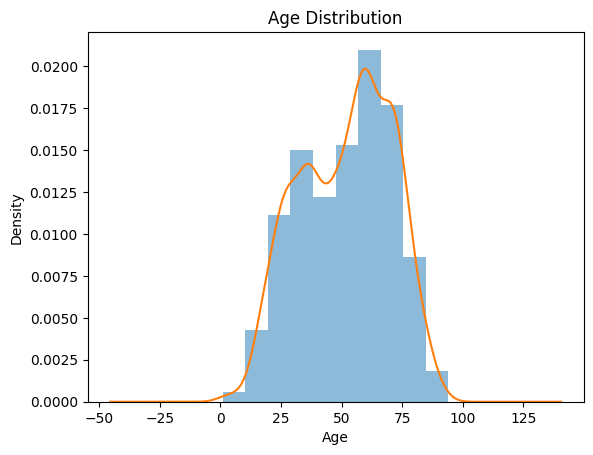

In [ ]:
ax = df['age'].plot.hist(bins=10, alpha=0.5, density=True)
df['age'].plot.kde(ax=ax)


plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')

plt.show()


In [ ]:
df['sex'].unique()

array(['F', 'M'], dtype=object)

In [ ]:
df['sex'] = df['sex'].map({'F' : 0, 'M' : 1})

In [ ]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41.0,0,f,f,f,f,f,f,f,f,...,f,f,f,1.30,2.5,125.0,1.14,109.0,SVHC,negative
1,23.0,0,f,f,f,f,f,f,f,f,...,f,f,f,4.10,2.0,102.0,NaN,NaN,other,negative
2,46.0,1,f,f,f,f,f,f,f,f,...,f,f,f,0.98,NaN,109.0,0.91,120.0,other,negative
3,70.0,0,t,f,f,f,f,f,f,f,...,f,f,f,0.16,1.9,175.0,NaN,NaN,other,negative
4,70.0,0,f,f,f,f,f,f,f,f,...,f,f,f,0.72,1.2,61.0,0.87,70.0,SVI,negative


In [ ]:
# # We can map the categorical values like below:
# df['sex'] = df['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
# so instead of mapping indvidually, let's do a smarter work
for column in df.columns[~df.columns.isin(['sex'])]:
    if  len(df[column].unique())==2:
        df[column] = df[column].map({'f' : 0, 't' : 1})
        
# this will map all the rest of the columns as we require. Now there are handful of column left with more than 2 categories. 

In [ ]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.30,2.5,125.0,1.14,109.0,SVHC,negative
1,23.0,0,0,0,0,0,0,0,0,0,...,0,0,0,4.10,2.0,102.0,NaN,NaN,other,negative
2,46.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0.98,NaN,109.0,0.91,120.0,other,negative
3,70.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0.16,1.9,175.0,NaN,NaN,other,negative
4,70.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.72,1.2,61.0,0.87,70.0,SVI,negative


In [ ]:
df['referral_source']

0        SVHC
1       other
2       other
3       other
4         SVI
        ...  
3767    other
3768      SVI
3769    other
3770      SVI
3771    other
Name: referral_source, Length: 3620, dtype: object

In [ ]:
# we will use get_dummies with that.
df = pd.get_dummies(df, columns=['referral_source'])

In [ ]:
# Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so we will just map them.
# Let's use LabelEncoder function for this.
df['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [ ]:
lblEn = LabelEncoder()

df['Class'] =lblEn.fit_transform(df['Class'])

In [ ]:
df['sex'].unique()

array([0, 1])

In [ ]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41.0,0,0,0,0,0,0,0,0,0,...,2.5,125.0,1.14,109.0,1,0,1,0,0,0
1,23.0,0,0,0,0,0,0,0,0,0,...,2.0,102.0,NaN,NaN,1,0,0,0,0,1
2,46.0,1,0,0,0,0,0,0,0,0,...,NaN,109.0,0.91,120.0,1,0,0,0,0,1
3,70.0,0,1,0,0,0,0,0,0,0,...,1.9,175.0,NaN,NaN,1,0,0,0,0,1
4,70.0,0,0,0,0,0,0,0,0,0,...,1.2,61.0,0.87,70.0,1,0,0,0,1,0


In [ ]:
df.isna().sum().sort_values(ascending=False)

T3                           745
T4U                          367
FTI                          365
TSH                          352
TT4                          217
age                            0
hypopituitary                  0
referral_source_SVI            0
referral_source_SVHD           0
referral_source_SVHC           0
referral_source_STMW           0
Class                          0
psych                          0
tumor                          0
sex                            0
goitre                         0
lithium                        0
query_hyperthyroid             0
query_hypothyroid              0
I131_treatment                 0
thyroid_surgery                0
pregnant                       0
sick                           0
on_antithyroid_medication      0
query_on_thyroxine             0
on_thyroxine                   0
referral_source_other          0
dtype: int64

In [ ]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(df) # impute the missing values
    # convert the nd-array returned in the step above to a Dataframe
new_data=pd.DataFrame(data=np.round(new_array), columns=df.columns)

In [ ]:
new_data.isna().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

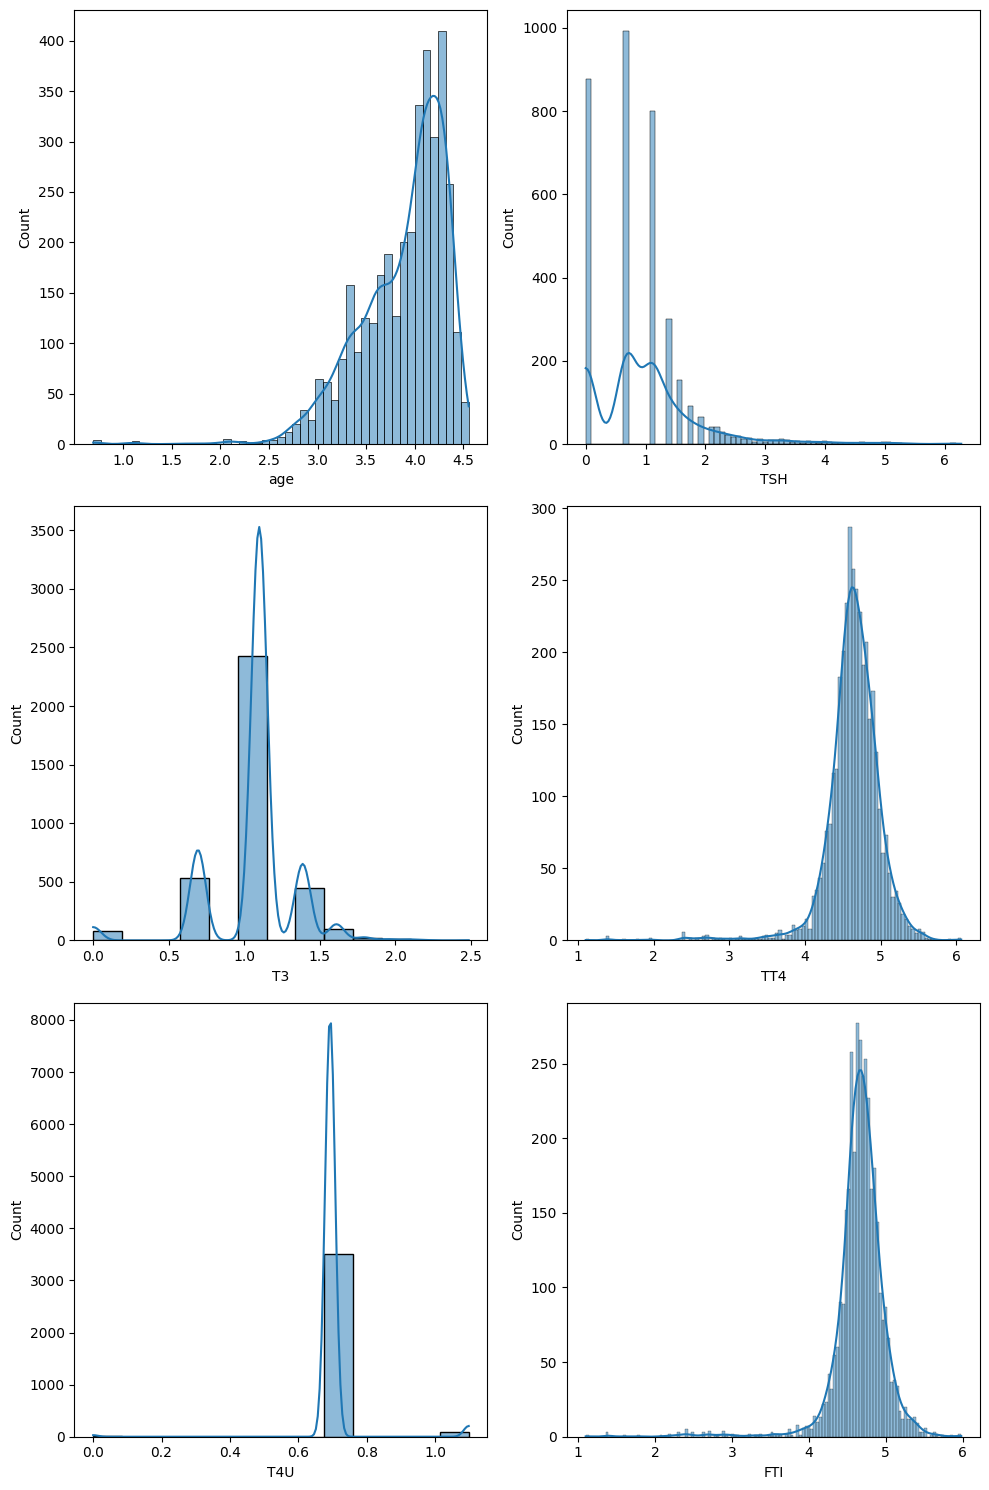

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), facecolor='white')
plotnumber = 0

for ax, column in zip(axes.flatten(), columns):
    new_data[column] += 1
    sns.histplot(np.log(new_data[column]), ax=ax, kde=True)
    ax.set_xlabel(column, fontsize=10)
    plotnumber += 1

plt.tight_layout()
plt.show()

In [ ]:
new_data = new_data.drop(['TSH'],axis=1)

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'T3', 'TT4', 'T4U', 'FTI',
       'Class', 'referral_source_STMW', 'referral_source_SVHC',
       'referral_source_SVHD', 'referral_source_SVI', 'referral_source_other'],
      dtype='object')

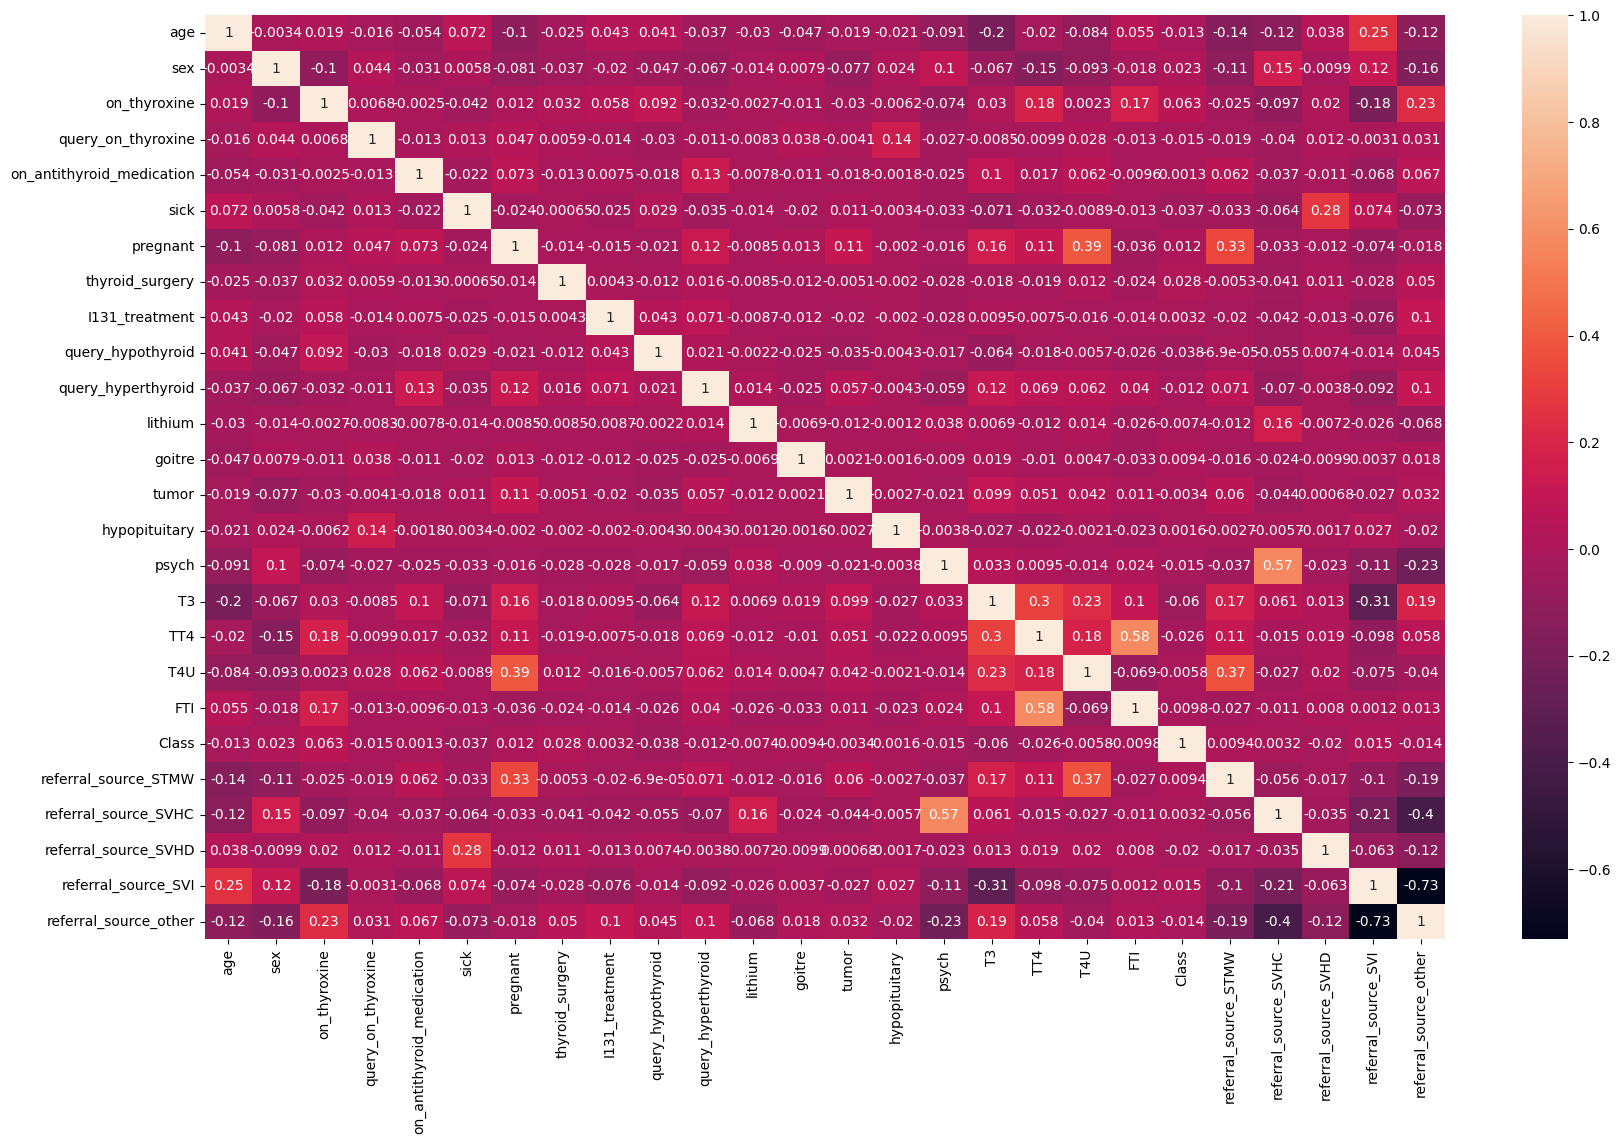

In [ ]:
# Calculate the Kendall rank correlation matrix of the encoded DataFrame
corr = new_data.corr(method='kendall')

# Set the size of the figure for the heatmap
plt.figure(figsize=(20,12))

# Create a heatmap of the Kendall rank correlation matrix using the seaborn library
sns.heatmap(corr, annot=True)

# list of columns
new_data.columns

0.0    2478
1.0    1142
Name: sex, dtype: int64


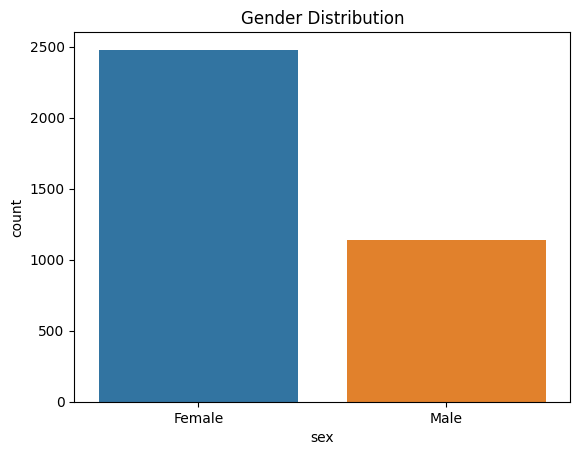

In [ ]:
print(new_data['sex'].value_counts())
ax = sns.countplot(x='sex',data=new_data)
ax.set(title='Gender Distribution')
ax.set_xticklabels(['Female', 'Male' ])
plt.show()


<Axes: xlabel='Class', ylabel='count'>

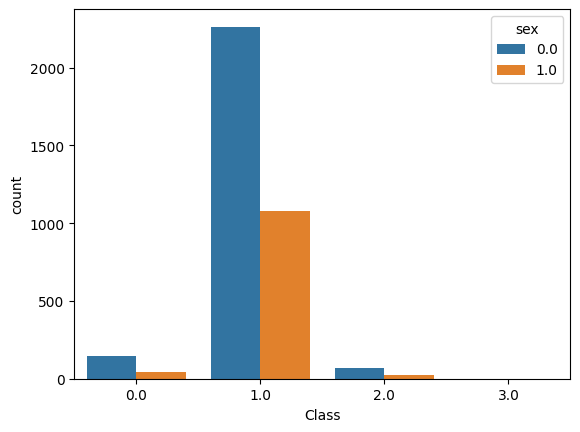

In [ ]:
sns.countplot(data = new_data, x='Class', hue='sex')

<Axes: xlabel='Class', ylabel='count'>

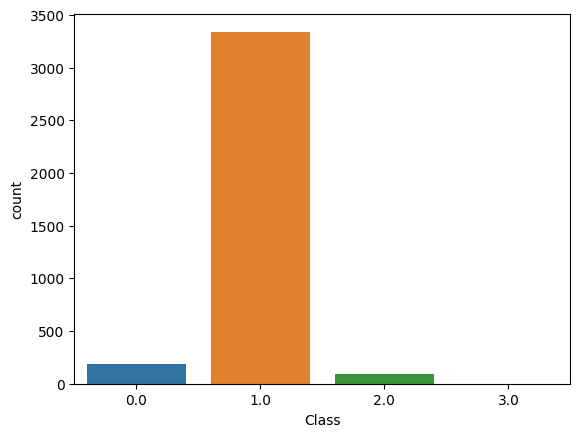

In [ ]:
sns.countplot(data = new_data, x='Class')

In [ ]:
# spliting input features and target feature
x = new_data.drop(['Class'],axis=1)
y = new_data['Class']

In [ ]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3620 entries, 0 to 3619
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3620 non-null   float64
 1   sex                        3620 non-null   float64
 2   on_thyroxine               3620 non-null   float64
 3   query_on_thyroxine         3620 non-null   float64
 4   on_antithyroid_medication  3620 non-null   float64
 5   sick                       3620 non-null   float64
 6   pregnant                   3620 non-null   float64
 7   thyroid_surgery            3620 non-null   float64
 8   I131_treatment             3620 non-null   float64
 9   query_hypothyroid          3620 non-null   float64
 10  query_hyperthyroid         3620 non-null   float64
 11  lithium                    3620 non-null   float64
 12  goitre                     3620 non-null   float64
 13  tumor                      3620 non-null   float

In [ ]:
# balancing the dataset
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x, y)

In [ ]:
x_sampled.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,176.0,2.0,147.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
x_sampled.shape

(13360, 25)

<Axes: xlabel='Class', ylabel='count'>

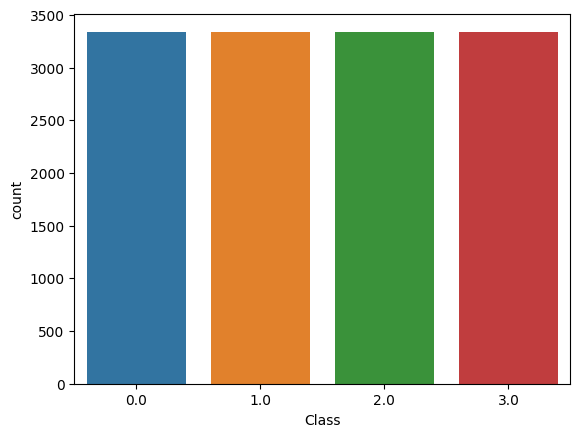

In [ ]:
sns.countplot(x=y_sampled)

## Create Functions for model training and evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_sampled,y_sampled,test_size=0.2,random_state=42)

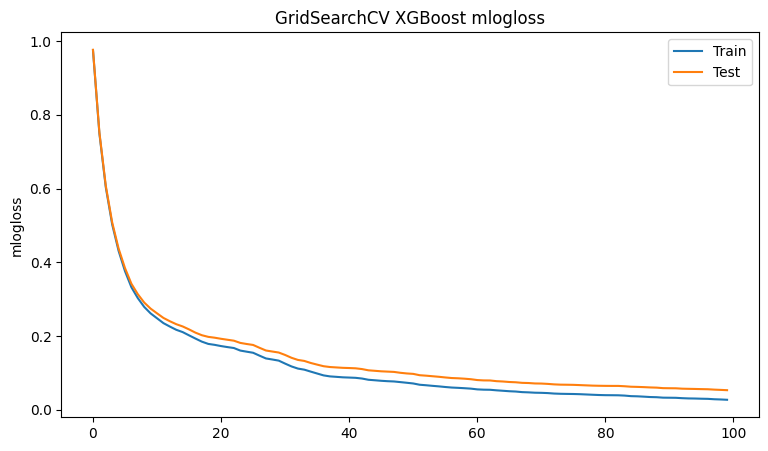

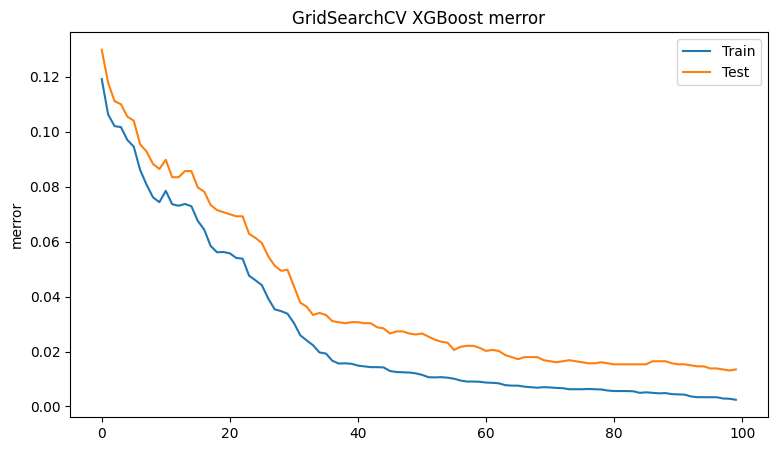


------------------ Confusion Matrix -----------------

[[662   0   0   0]
 [ 31 638   5   0]
 [  0   0 668   0]
 [  0   0   0 668]]

Accuracy: 0.99
Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       662
         1.0       1.00      0.95      0.97       674
         2.0       0.99      1.00      1.00       668
         3.0       1.00      1.00      1.00       668

    accuracy                           0.99      2672
   macro avg       0.99      0.99      0.99      2672
weighted avg       0.99      0.99      0.99      2672

---------------------- XGBoost ----------------------


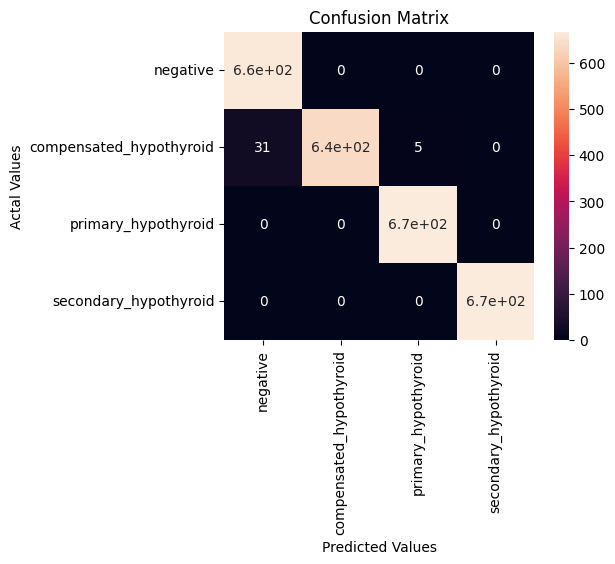

In [ ]:
model = XGBClassifier(objective='multi:softmax', 
                            num_class=4,  
                            early_stopping_rounds=15, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
model.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)]) 
            
results = model.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
/

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'], 
                     columns = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

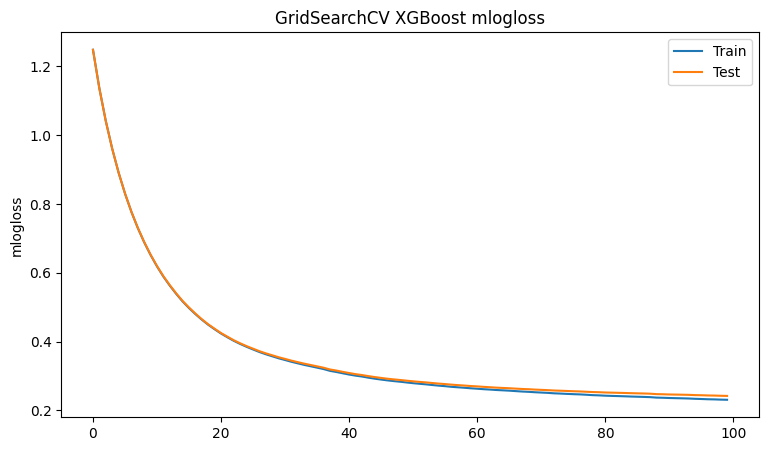

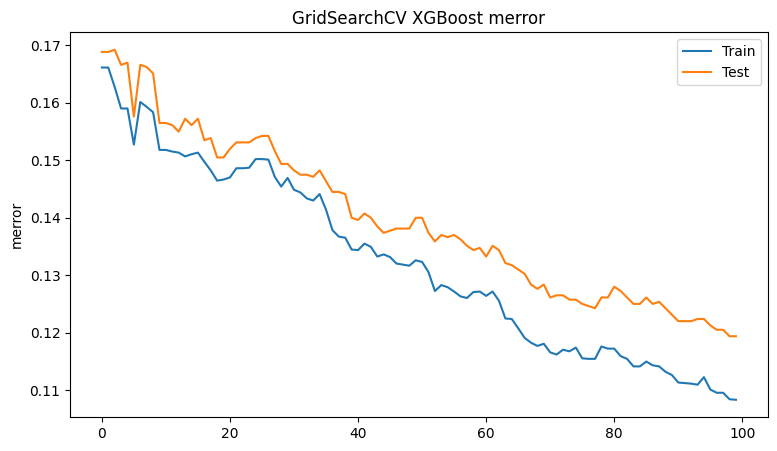


------------------ Confusion Matrix -----------------

[[548 114   0   0]
 [199 469   6   0]
 [  0   0 668   0]
 [  0   0   0 668]]

Accuracy: 0.88
Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.88
Macro Recall: 0.88
Macro F1-score: 0.88

Weighted Precision: 0.88
Weighted Recall: 0.88
Weighted F1-score: 0.88

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78       662
         1.0       0.80      0.70      0.75       674
         2.0       0.99      1.00      1.00       668
         3.0       1.00      1.00      1.00       668

    accuracy                           0.88      2672
   macro avg       0.88      0.88      0.88      2672
weighted avg       0.88      0.88      0.88      2672

---------------------- XGBoost ----------------------


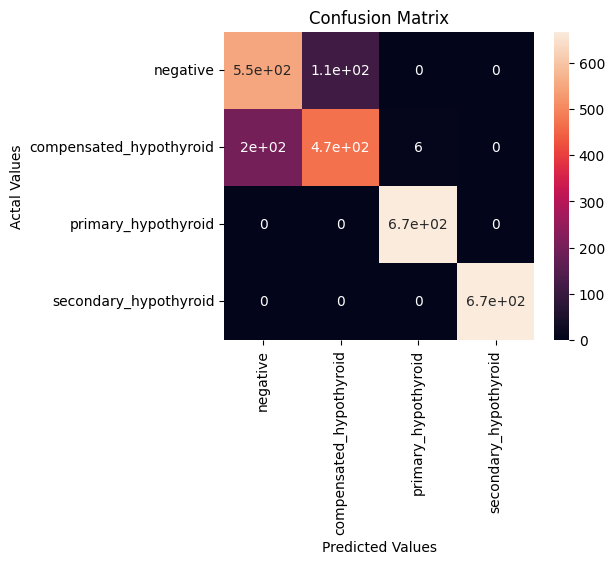

In [ ]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters 

# declaring and fitting xgb classifier
model = XGBClassifier(objective='multi:softmax', 
                            num_class=4, 
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
model.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            #sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))


print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'], 
                     columns = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

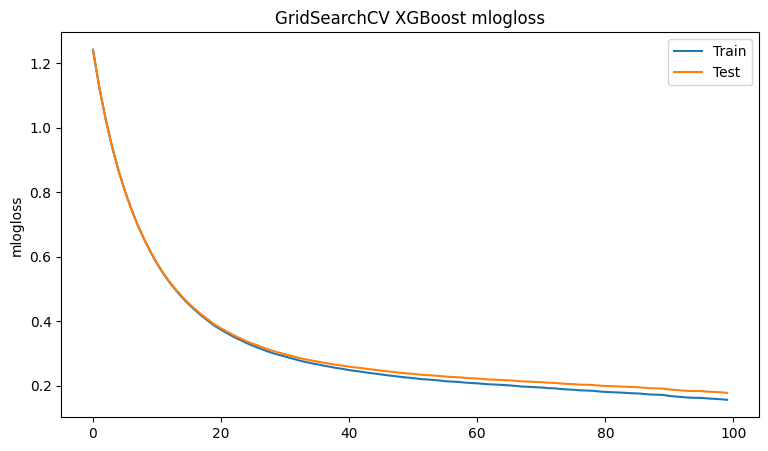

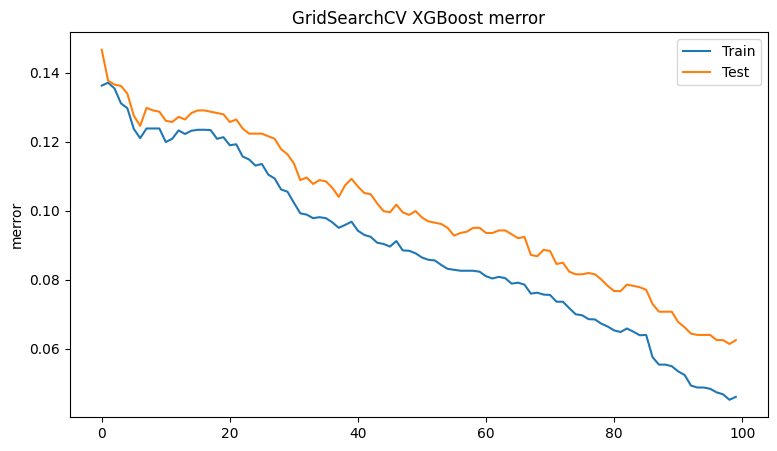


------------------ Confusion Matrix -----------------

[[637  25   0   0]
 [136 532   6   0]
 [  0   0 668   0]
 [  0   0   0 668]]

Accuracy: 0.94
Micro Precision: 0.94
Micro Recall: 0.94
Micro F1-score: 0.94

Macro Precision: 0.94
Macro Recall: 0.94
Macro F1-score: 0.94

Weighted Precision: 0.94
Weighted Recall: 0.94
Weighted F1-score: 0.94

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.89       662
         1.0       0.96      0.79      0.86       674
         2.0       0.99      1.00      1.00       668
         3.0       1.00      1.00      1.00       668

    accuracy                           0.94      2672
   macro avg       0.94      0.94      0.94      2672
weighted avg       0.94      0.94      0.94      2672

---------------------- XGBoost ----------------------


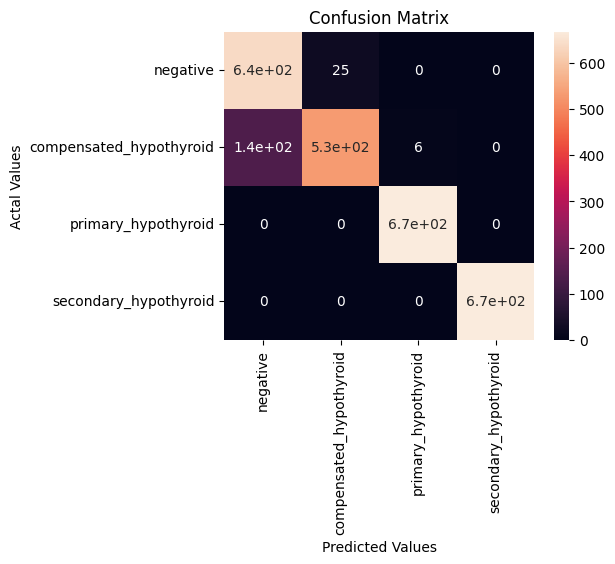

In [ ]:
## ---------- XGBoost model v3 ----------
## third run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
# sample_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train)

# declaring and fitting xgb classifier
model = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, # re-optimized from v2
                            reg_lambda=1, # default L2 value
                            #subsample=0.8, # tried but not ideal
                            #colsample_bytree=0.3, # tried but not ideal
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
model.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'], 
                     columns = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


------------------ Confusion Matrix -----------------

[[620  42   0   0]
 [141 528   5   0]
 [  0   6 662   0]
 [  0   0   0 668]]

Accuracy: 0.93
Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.93
Macro Recall: 0.93
Macro F1-score: 0.93

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87       662
         1.0       0.92      0.78      0.84       674
         2.0       0.99      0.99      0.99       668
         3.0       1.00      1.00      1.00       668

    accuracy                           0.93      2672
   macro avg       0.93      0.93      0.93      2672
weighted avg       0.93      0.93      0.93      2672

---------------------- Random Forest ----------------------


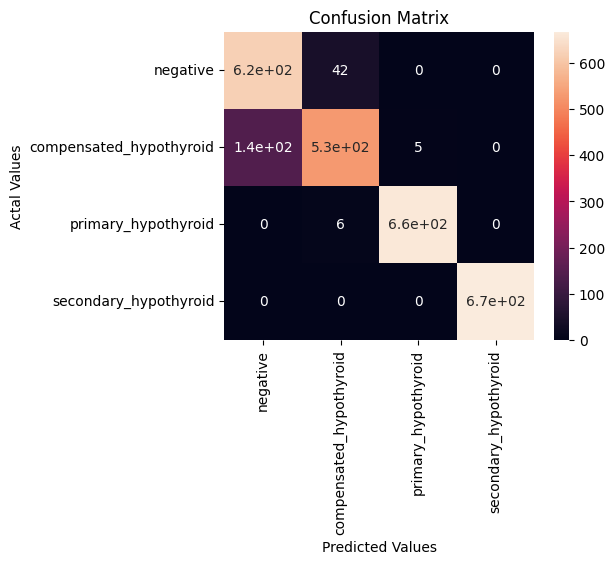

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest model
model = RandomForestClassifier(n_estimators=100, 
                                max_depth=10, 
                                min_samples_split=2, 
                                min_samples_leaf=1,
                                criterion='gini', 
                                n_jobs=-1, 
                                random_state=42)

# Fit the model to your training data
model.fit(X_train, 
            y_train)
y_pred = model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- Random Forest ----------------------') # unnecessary fancy styling

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'], 
                     columns = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


------------------ Confusion Matrix -----------------

[[662   0   0   0]
 [ 37 636   1   0]
 [  0   0 668   0]
 [  0   0   0 668]]

Accuracy: 0.99
Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       662
         1.0       1.00      0.94      0.97       674
         2.0       1.00      1.00      1.00       668
         3.0       1.00      1.00      1.00       668

    accuracy                           0.99      2672
   macro avg       0.99      0.99      0.99      2672
weighted avg       0.99      0.99      0.99      2672

---------------------- Random Forest ----------------------


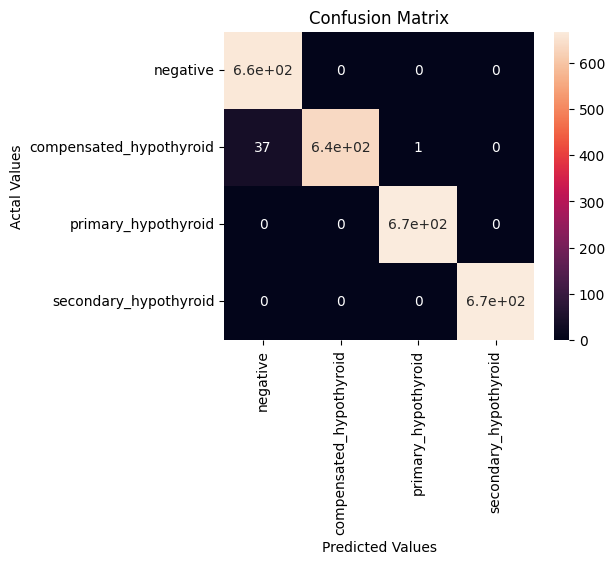

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a random forest model
model = DecisionTreeClassifier(max_depth=20, random_state=42)

# Fit the model to your training data
model.fit(X_train, 
            y_train)
y_pred = model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- Decision Tree ----------------------') # unnecessary fancy styling

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'], 
                     columns = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=42)

# 'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4] 
              
param_grid = {'max_depth': [10, 20, 30, 40], 'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4] }

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best cross-validation score:', grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

Best hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.981474733776532
Accuracy: 0.9898952095808383
Precision: 0.9902379201708685
Recall: 0.9898952095808383
F1 score: 0.98987919929524



------------------ Confusion Matrix -----------------

[[662   0   0   0]
 [110 559   5   0]
 [  0   0 668   0]
 [  0   0   0 668]]

Accuracy: 0.96
Micro Precision: 0.96
Micro Recall: 0.96
Micro F1-score: 0.96

Macro Precision: 0.96
Macro Recall: 0.96
Macro F1-score: 0.96

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1-score: 0.96

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       662
         1.0       1.00      0.83      0.91       674
         2.0       0.99      1.00      1.00       668
         3.0       1.00      1.00      1.00       668

    accuracy                           0.96      2672
   macro avg       0.96      0.96      0.96      2672
weighted avg       0.96      0.96      0.96      2672

---------------------- KNN ----------------------


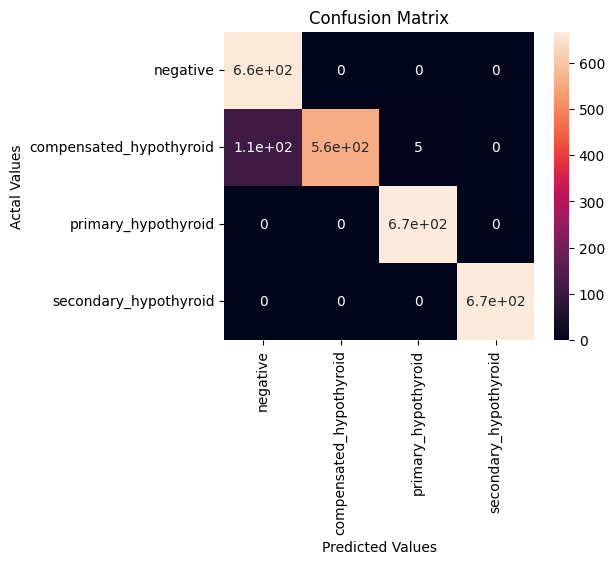

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create a random forest model
model = KNeighborsClassifier(n_neighbors=5)

# Fit the model to your training data
model.fit(X_train, 
            y_train)
y_pred = model.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- KNN ----------------------') # unnecessary fancy styling

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'], 
                     columns = ['negative',
                              'compensated_hypothyroid',
                              'primary_hypothyroid',
                              'secondary_hypothyroid'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","precision","recall","f1-score"]
pt.add_row(["XGBClassifier v1","0.99","0.99","0.99"])
pt.add_row(["XGBoost model v2","0.88","0.88","0.88"])
pt.add_row(["XGBoost model v3",'0.94', '0.94', '0.94'])
pt.add_row(["RandomForest Classifier",'0.93', '0.93', '0.93'])
pt.add_row(["DecisionTree Classifier",'0.99', '0.99', '0.99'])
pt.add_row(["KNeighborsClassifier",'0.96', '0.96', '0.96'])

print(pt)

+-------------------------+-----------+--------+----------+
|          Model          | precision | recall | f1-score |
+-------------------------+-----------+--------+----------+
|     XGBClassifier v1    |    0.99   |  0.99  |   0.99   |
|     XGBoost model v2    |    0.88   |  0.88  |   0.88   |
|     XGBoost model v3    |    0.94   |  0.94  |   0.94   |
| RandomForest Classifier |    0.93   |  0.93  |   0.93   |
| DecisionTree Classifier |    0.99   |  0.99  |   0.99   |
|   KNeighborsClassifier  |    0.96   |  0.96  |   0.96   |
+-------------------------+-----------+--------+----------+
